# Big Data Platform
## Final Project: Small files in MapReduce jobs

**By:**  

Ayala Raanan, 040474934  

Sofia Budman, 314059155

Natalia Meergus, 319374039

<br><br>

### Objective  

In this work we implement a suggested solution for executing MapReduce on small files in object storage.
Our approach controls the amount of data received by one Map operation by using InputSplits.  
InputSplits are created in a preprocessing procedure to indicate groups of files that can be processed together in one Map task. This method can work on any existing cluster and requires only metadata operation for small files.   

### Implementation 

We tried to imitate the structure of swift to some degree. We created a cluster object with a known number of object servers. Files were stored in different servers according to hashing done by a ‘ring server’.  
A ‘metadata’ object holds metadata for the stored files by partition. In reality, metadata is stored locally with the data in each partition.  
An InputSplit object holds the information for the potential merging of files in this split.  
We used only CSV files as our source files for simplicity. We generated many small files as well as a few large files. We extended our InputSplit definition to work both with small files and with big files. After defining the target size for MapReduce data, we cluster small files until they can’t fit into the target size. If the file is larger than the target size, InputSplit will peek into the file using some utility functions, find the right places to cut it and remember them in InputSplits.

### Prerequisites

**Imports**

In [66]:
# general
import os
from pathlib import Path
import shutil
import sqlite3
import random
import warnings
import concurrent.futures # used as threading package
import csv
import io  # for StringIO
import hashlib

# ml
import numpy as np
import pandas as pd

# visual
import matplotlib.pyplot as plt
# notebook
from IPython import display

**Hide Warnings**

In [67]:
warnings.filterwarnings('ignore')

**Set Random Seed**

In [68]:
random.seed(123)

### Setup

Here we create the files (both small and not) which we'll later upload to our "object storage".  
The file format we use for simplicity is csv, as in assignment 2 instructions.  
The default block size in our sample "object storage" is defined as 1000 bytes.  
Thus, the "small files" are the files considerably smaller than 1000 bytes.  


In [69]:
def creat_data(num_files, rec_per_file, filename_ext):
  firstname = ['John', 'Dana', 'Scott', 'Marc', 'Steven', 'Michael', 'Albert', 'Johanna']
  city = ['NewYork', 'Haifa', 'Munchen', 'London', 'PaloAlto',  'TelAviv', 'Kiel', 'Hamburg']
  # We use dataframe to csv to convert each created table to csv
  created_files = []
  for file_num in range(num_files):
    df = pd.DataFrame({'firstname': np.random.choice(firstname, rec_per_file),
                      'secondname': np.random.randint(0, 21, rec_per_file),
                      'city': np.random.choice(city, rec_per_file)})

    filename = f'myCSV{file_num+1}_{filename_ext}.csv'
    df.to_csv(filename, index=False, line_terminator='\n')
    created_files.append(filename)
  return created_files

# create small files
num_files = 200
rec_per_file = 3  # just few dozens of bytes, far smaller than 1 block size, i.e. small file
filename_ext = 'small'
created_small_files = creat_data(num_files, rec_per_file, filename_ext)

# create big files
num_files = 20
rec_per_file = 100  # ~1.5 KB-size files, above 1 block (1000 bytes in our example)
filename_ext = 'big'
created_big_files = creat_data(num_files, rec_per_file, filename_ext)

### Ring object
The ring keeps a mapping of partitions to actual devices.
It uses md5 hashing to determine the location of the file by its name.

In [70]:
# Ring class
class Ring():
    def __init__(self, servers_number):
        self.servers_number = servers_number
        # partition to server is a dict mapping partition i to location "partitioni"
        self.partition_to_server = {i:'partition' + str(i) for i in range(self.servers_number)}

    # Get object hashed name ("iNode") by filename
    def hashed_name_by_ring(self, filename): 
        h_digest = hashlib.md5(filename.encode()).hexdigest()
        f = Path(filename)
        t = f.stat().st_ctime # file creation time
        part_key = int(h_digest[:3], 16)
        partition = part_key % self.servers_number
        name = str(partition) + '_' + h_digest + '_' + str(t) +'.csv' 
        return name

    # Get object location by filename
    def location_by_ring(self, filename):
        h_digest = hashlib.md5(filename.encode()).hexdigest()
        part_key = int(h_digest[:3], 16)
        partition = part_key % self.servers_number
        return self.partition_to_server[partition]

### Metadata handling
In our object storage, the object's metadata consists of just few basic details about the file:
original filename, file size and creation time stamp.
A hash name (known as iNode in some implementations) is an object's key.
Metadata for all objects in the partition is stored in the same partition for the sake performance (locality).

In [71]:
class Metadata():
  def __init__(self, partition):
    self.partition = partition
    self.metadata_name = Path(partition) / 'metadata.csv'

  # initialization of partition's metadata
  def Create(self):
    with self.metadata_name.open('w') as out:
        csv_out = csv.writer(out)
        csv_out.writerow(['hash_name', 'FileName', 'FileSize', 'FileCreationTime'])

  # Update the metadata following "upload" of a new object to the object storage
  def Append(self, hashed_name, filename, file_size, file_creation_time):
    with self.metadata_name.open('a') as out:
      csv_out = csv.writer(out)
      csv_out.writerow([hashed_name, filename, file_size, file_creation_time])
  
  # Pre-read size information
  def files_sizes(self, file_list = None):
    with self.metadata_name.open('r') as meta:
      meta_df = pd.read_csv(meta)
      meta_df_partial = meta_df[['FileName', 'FileSize']]
      if file_list:
        file_size_tuples = (meta_df_partial[meta_df_partial['FileName'].isin(file_list)]).to_records(index=False)
      else:
        file_size_tuples = meta_df_partial.to_records(index=False)
    return file_size_tuples

### Cluster

We create a cluster with a known number of partitions.  
The cluster holds its ring and maintains its metadata.
A PUT operation enables files to be added to the cluster.  
A function to upload a list of files is also provided.

In [72]:
#prepare the cluster (skipping buckets)

class Object_storage_cluster():
    # Initialize new partitions in our object storage
    def __init__(self, servers_number):
        self.servers_number = servers_number
        self.ring = Ring(self.servers_number)
        for p in self.ring.partition_to_server.values():
            partition = Path(p)
            print(partition)
            if (partition.exists()):
              shutil.rmtree(partition)
            partition.mkdir(exist_ok=False)
            Metadata(p).Create()

    # Upload a new object into object storage    
    def PUT(self, filename):
        p = self.ring.location_by_ring(filename)
        target_server = Path(p)
        hashed_name = self.ring.hashed_name_by_ring(filename)
        target_file = target_server / hashed_name
        shutil.copy(Path(filename), target_file)
        # now_metadata file
        f = Path(target_file)
        file_timestamp = f.stat().st_ctime
        file_size = f.stat().st_size
        Metadata(p).Append(hashed_name, filename, file_size, file_timestamp)

    # Find a object by its filename
    def GET(self, filename):
        target_server = Path(self.ring.location_by_ring(filename))
        hashed_name = self.ring.hashed_name_by_ring(filename)
        target_file = target_server / hashed_name
        return target_file
    
    # Bulk upload of group of files into the object storage
    def load_files_to_cluster(self, datasource): # datasource is a list of files
        for filename in datasource:
            self.PUT(filename)

### InputSplits

Here we define the objects needed for controling MapReduce inputs.
InputSplits hold a list of tuples defines by the files to be processed together by one Map task. Each tuple contains the file name, its size and the cut positions (if it is a big file). An InputSplit has a maximal size and holds the accumulated sizes of the files it groups together.
combine_files_to_InputSplits goes over the files requested and returns their partition into a list of InputSplits.  
In case of small files, it groups them together. In case of large files it chunks them and saves the target cut positions in the InputSplit.


In [73]:
# basic data chunk for Map processing
class InputSplit():
    def __init__(self, max_size):
        self.max_size = max_size
        self.s_list = []
        self.size = 0
    
    # Add a new object (or portion of it) to the chunk
    def append_file(self, filename, size, from_pos = 0, cut_size = -1):
        if (cut_size == -1):
          cut_size = size - from_pos
        self.s_list.append((filename, size, from_pos, cut_size))
        self.size += cut_size


class Object_storage_CombineFileInputFormat():
    def __init__(self, cluster, max_combined_size, files_list = None):
        self.max_combined_size = max_combined_size
        self.cluster = cluster
        self.files_list = files_list

    def combine_files_to_InputSplits(self):
        splits_list = []
        for p in self.cluster.ring.partition_to_server.values():
            meta_p = Metadata(p).files_sizes(self.files_list)
            input_split = InputSplit(self.max_combined_size)
            for record in meta_p:
                file = record[0]
                size = record[1]
                if input_split.size + size < input_split.max_size:
                    # Small file, fully fitting in the chunk's remaining free space
                    input_split.append_file(file, size)
                else:
                    if input_split.size:
                      # Current InputSplit is full, so just pack it
                      splits_list.append(input_split)
                      # Start new InputSplit
                      input_split = InputSplit(self.max_combined_size)
                    if (size <= self.max_combined_size):
                      # Small file
                      input_split.append_file(file, size)
                    else:
                      # Large file, need to be divided to blocks and each block packed into its own InputSplit
                      cut_start = 0
                      while (size - cut_start >= input_split.max_size):
                        input_split.append_file(file, size, cut_start, input_split.max_size)
                        cut_start += input_split.max_size
                        splits_list.append(input_split)
                        input_split = InputSplit(self.max_combined_size)
                      if (cut_start < size):
                        # Last block of the object
                        input_split.append_file(file, size, cut_start)
                        splits_list.append(input_split)
                        input_split = InputSplit(self.max_combined_size)
            if input_split.size:
              # Pack the last InputSplit
              splits_list.append(input_split)
        self.splits = splits_list
        return self.splits

### MapReduce infrastructure

**Praparing folders**

In [74]:
# directory constants definition and creation
MR_TEMP_DIR = Path('mapreducetemp')
MR_FINAL_DIR = Path('mapreducefinal')
MR_TEMP_DIR.mkdir(exist_ok=True)
MR_FINAL_DIR.mkdir(exist_ok=True)

**Preparing database for sort and shuffle stage**

In [75]:
# Establishing sql connection and creating the table according to the defined schema
sql_conn = sqlite3.connect('mydb.db')
cur = sql_conn.cursor()

cur.execute('''
          CREATE TABLE IF NOT EXISTS temp_results (
          key TEXT,
          value TEXT
          )''')
sql_conn.commit()

**Utility functions for chunkung big files**  
When a given a target cut for a file, these functions look for the exact positions to cut the file, so that complete records are kept and no data is missing or correupted.

In [76]:
# We want each InputSplit to contain correct input for MapReduce
# In our case, when objects are csv file, that means that:
# - each InputSplit must have a header
# - each InputSplit must contain the whole line (not broken lines)
# When dividing csv file, don't cut the line in the middle.
# Instead find the start of the line and divide at that position
def get_linestart(f, size, pos):
  if (pos in [0, size]):
    return pos
  for i in range(1, pos):
    f.seek(pos-i)
    if (f.read(1) == '\n'):
      return pos-i+1
  return 0  # unreal case that we was in the very first line in the file

# Cut the object close to requested position, producing correct csv input
# (with header and whole lines)
def read_csv_chunk(filename, size, est_from_pos, cut_size):
  with open(filename) as f:
    from_pos = get_linestart(f, size, est_from_pos)
    to_pos = get_linestart(f, size, est_from_pos + cut_size)
    if from_pos > 0:
      f.seek(0)
      header = f.readline() 
    else:
      header = '' # for from_pos 0 the header is already inside the chunk
    f.seek(from_pos)
    chunk = f.read(to_pos - from_pos)
    # Now it's correct csv which can be loaded using read_csv
    df_chunk = pd.read_csv(io.StringIO(header + chunk))
    return df_chunk

### MapReduce engine  

Mappers are now assignes an InputSplit instead of a single file.  
The main adjustment required was adding the record_reader function. This function can interprate InputSplit and pass the Map function keys/values. It aggaregates data from small files or returns the chunk from a big file.  
Record_reader also passes the filename of the source.

In [77]:
# implement all of the class here

class MapReduceEngine():
    # Combine all objects in the InputSplit (small objects or portions of large objects) into 1 input for the MapReduce
    def record_reader(self, input_split):
      Files_data_df = pd.DataFrame() 
      for (file, size, from_pos, cut_size) in input_split.s_list:
        if from_pos == 0 and size == cut_size:
          temp_df = pd.read_csv(file)
        else:
          temp_df = read_csv_chunk(file, size, from_pos, cut_size)
          
        temp_df['Source'] = file
        Files_data_df = pd.concat([Files_data_df, temp_df])
      return Files_data_df.reset_index()

    def map_wrapper(self, func, target_file, key, column_index):
      # This wrapper function handles saving the results returned from either map or reduce functions
      # It calls the function with its inputs and saves the output list at the designated target file
      merged_data = self.record_reader(key)
      results = func(merged_data, column_index)

      with target_file.open('w', newline='') as out:
          csv_out = csv.writer(out)
          csv_out.writerows(results)

    def reduce_wrapper(self, func, target_file, *args):
      # This wrapper function handles saving the results returned from either map or reduce functions
      # It calls the function with its inputs and saves the output list at the designated target file
      results = func(*args)
      with target_file.open('w', newline='') as out:
          csv_out = csv.writer(out)
          csv_out.writerows([results])

    def execute(self, splits, map_function, reduce_function, params):
      # mapreduce execution enging
      map_threads = [] # keeps track of deployment threads and their execution state
      temp_files = [] # keeps track of temp_file names created. Later used to upload to SQL database
      column_index = params['column'] # reducing 1 for requested column for mapping, since the example showed interface numbering starts at 1 (not 0)
      with concurrent.futures.ThreadPoolExecutor() as executor:
          for idx, key in enumerate(splits, start=1):
              temp_file = MR_TEMP_DIR / f'part-tmp-{idx}.csv'
              th = executor.submit(self.map_wrapper, map_function, temp_file, key, column_index)
              map_threads.append(th)
              temp_files.append(temp_file)
          concurrent.futures.wait(map_threads) # concurrent futures will return only after completion of all threads. Optionally, use timeout.

      # Next stage - loading data from csv files to SQL database according to schama (again, using pandas)
      for t_file in temp_files:
        data = pd.read_csv(t_file, names=['key', 'value'])
        data.to_sql('temp_results', sql_conn, if_exists='append', index=False)
      # The following query will return 2 columns for key, and all concatenated filenames containing this key
      # Order by key may help later. 
      # If we look for a key in the reduce filenames, we can narrow down the search if keys are ordered along with the reduce filenames list 
      query = '''SELECT key, GROUP_CONCAT(value) 
                  FROM temp_results
                  GROUP BY key
                  ORDER BY key'''
      
      key_doc = cur.execute(query).fetchall()
      
      reduce_threads = []
      # final_files = [] # we do not use this list in this exercise, but it should obviously be kept for real application
      status = 'MapReduce Failed' #Just the init state
      with concurrent.futures.ThreadPoolExecutor() as executor:
          for idx, (key, value) in enumerate(key_doc, start=1):
              fin_file = MR_FINAL_DIR / f'part-{idx}-final.csv'
              th = executor.submit(self.reduce_wrapper, reduce_function, fin_file, key, value)
              reduce_threads.append(th)
              # final_files.append(fin_file)
          wait_return = concurrent.futures.wait(reduce_threads, timeout = 300) # we use a timeout for indicating a problem with execution.
          if not wait_return.not_done: # if concurrent futures returns and no timeout - all threads have finished reduce operation.
            status = 'MapReduce Completed'
      
      return status
      

### Map function

In [78]:
def inverted_map(data, column_index):
    # start by reading the requested file and extracting relevant data
    # This is one place where it hurts to have a csv over columner storage, if only one column is requested.
    data_keys = data.columns.to_list()
    data_values = data.values.astype(str)
    doc_index = len(data_keys) - 1

    # For the requested column, make a list of tuples of the form (key_value, document name)
    output_list = [('_'.join((data_keys[column_index], data_values[i, column_index])), data_values[i, doc_index]) for i in range(data_values.shape[0])]
    return output_list


### Reduce function

In [79]:
def inverted_reduce(key, documents):
    # This function splits the concatenated names in 'documents' to list -> unique, using set -> joins back to list of unique names
    output_list = [key, ','.join(list(set(documents.split(','))))]
    return output_list

### Submitting MapReduce  

* We have created our small and big files above.  
* A cluster is defined with 5 partitions.  
* We can decide below which files to upload into the cluster and which files we wish MapReduce to process (default is for the complete cluster).  
* The target size of an InputSplit is defined as 1000 bytes (= input size for a mapper)
* An Object_storage_CombineFileInputFormat is initiated.  
* We run the combine_files_to_InputSplits procedure.  
* MapReduce engine is executed on the created InputSplits.


In [80]:
# The "main" function
# 3 options to prepare test data for the MapReduce 
cluster_input_data = created_small_files + created_big_files
# mr_input_data = created_small_files
# mr_input_data = created_big_files
mr_input_data = created_small_files + created_big_files

servers_number = 5
cluster = Object_storage_cluster(servers_number)
cluster.load_files_to_cluster(cluster_input_data)

max_size = 1000  # default block size
# combined = Object_storage_CombineFileInputFormat(cluster,max_size) # without a list, this executes MapReduce on the entire cluster
combined = Object_storage_CombineFileInputFormat(cluster, max_size, mr_input_data)

splits = combined.combine_files_to_InputSplits()

mapreduce = MapReduceEngine()
status = mapreduce.execute(splits, inverted_map, inverted_reduce, params = 
{'column':1})
print(status)

partition0
partition1
partition2
partition3
partition4
MapReduce Completed


### Results  

The outcome of this effort is reflected in the size of the mappers outputs, stored the temporary files.  
If we do not delete the temporary files and examine them, we find that all files are approximately of the same size. This inidicates that the accumulated input data for the mappers was of the same size as intended.  
A few of the resulting files are smaller. This is because they are the remainder of the data in their partition (they could not be grouped with more files).

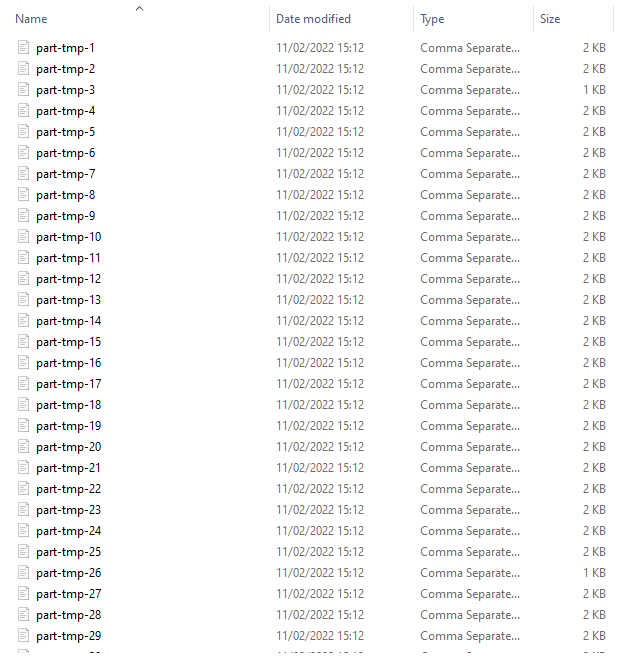

In [81]:
display.Image("./Map_results.png")

**Deleting temporary files and SQLite database**

In [82]:
# for f in MR_TEMP_DIR.iterdir():
#   f.unlink()

cur.close()
sql_conn.close()
os.remove('mydb.db')